In [26]:
%matplotlib notebook
import importlib
from matplotlib import pyplot as plt
from input_encoding.population_coding.utils import gaussian, gen_population_coding
import lvq.lvq1
import lvq.lvq2
from lvq.lvq1 import LVQ1
from lvq.lvq2 import LVQ2
from sklearn import datasets
from sklearn.datasets import load_iris
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
from som import SOM

In [ ]:
with open('C:/Users/ehajizad/lava-nc/neuromorphic-continual-learning/tutorials/filtered_coil20.npy', 'rb') as f:
    filtered = np.load(f, allow_pickle=True)

In [27]:
with open('C:/Users/ehajizad/lava-nc/neuromorphic-continual-learning/tutorials/coil20_labels.npy', 'rb') as f:
    labels = np.load(f, allow_pickle=True)

In [28]:
with open('C:/Users/ehajizad/lava-nc/neuromorphic-continual-learning/tutorials/strided_coil20.npy', 'rb') as f:
    stride_filtered = np.load(f, allow_pickle=True)

In [4]:
scaled_input = 100 * stride_filtered
scaled_input = scaled_input.reshape((scaled_input.shape[0], stride_filtered.shape[1],-1))
print(scaled_input.shape)
flat_input=scaled_input.reshape((scaled_input.shape[0], -1))
print(flat_input.shape)

(1440, 8, 441)
(1440, 3528)


<IPython.core.display.Javascript object>


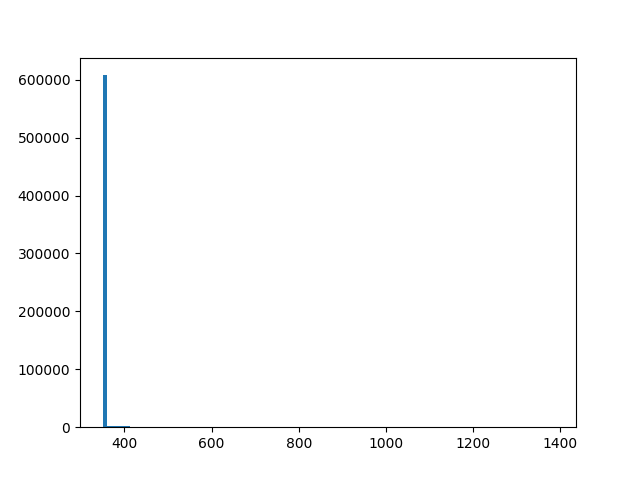

In [28]:
# now mostly the activation per patch is the same
sum_per_patch = bounded.sum(1)
plt.figure()
plt.hist(sum_per_patch.flatten(),100)
plt.show()

In [114]:
from scipy.spatial.distance import pdist, squareform

def min_max_scale(data):
    d_min = data.min()
    d_max = data.max()
    return (data-d_min)/(d_max-d_min)

input_feat = stride_filtered
flat_input_feat = stride_filtered.reshape((stride_filtered.shape[0], -1))

# euclidian distance similarity for population coded data
distances = pdist(flat_input_feat, metric='euclidean')
dist_matrix = squareform(distances)
dist_matrix = min_max_scale(dist_matrix)
euc_sim_pc = 1/np.exp(dist_matrix)


# dot product similarity on u_data_flat_scaled
u_data_sim = np.matmul(flat_input_feat,flat_input_feat.T)
u_data_sim_sc = min_max_scale(u_data_sim)

v_th=400
u_data_th1 = np.copy(u_data_sim)
u_data_th1[u_data_th1>=v_th] = v_th
u_data_th1_sc = min_max_scale(u_data_th1)

<IPython.core.display.Javascript object>


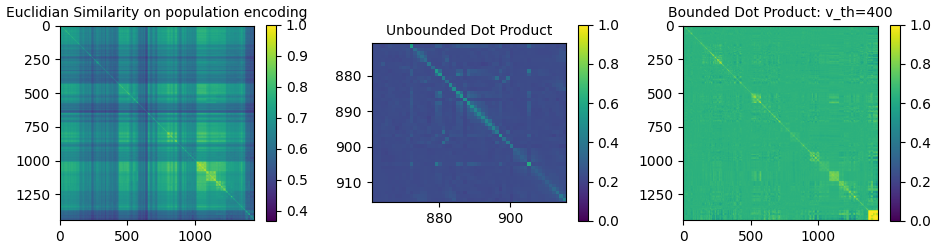

In [115]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9.5,2.5))

im1 = ax1.imshow(euc_sim_pc)
im2 = ax2.imshow(u_data_sim_sc)
im3 = ax3.imshow(u_data_th1_sc)
ax1.set_title("Euclidian Similarity on population encoding", fontsize=10)
ax2.set_title("Unbounded Dot Product", fontsize=10)
ax3.set_title("Bounded Dot Product: v_th=400", fontsize=10)
fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
fig.colorbar(im3, ax=ax3)
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


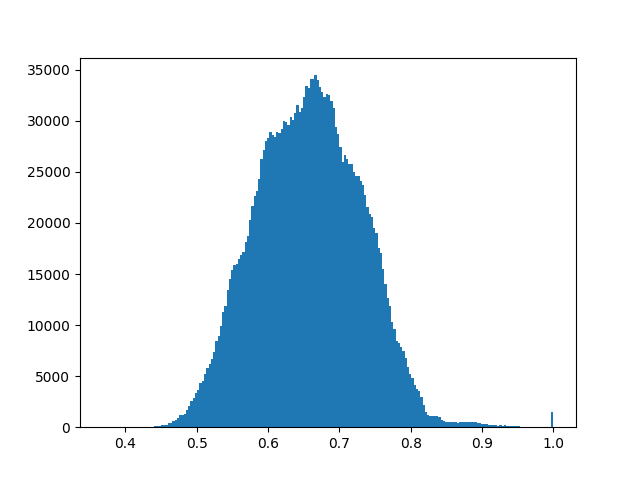

In [94]:
plt.figure()
plt.hist(euc_sim_pc.flatten(),200)
plt.show()

<IPython.core.display.Javascript object>


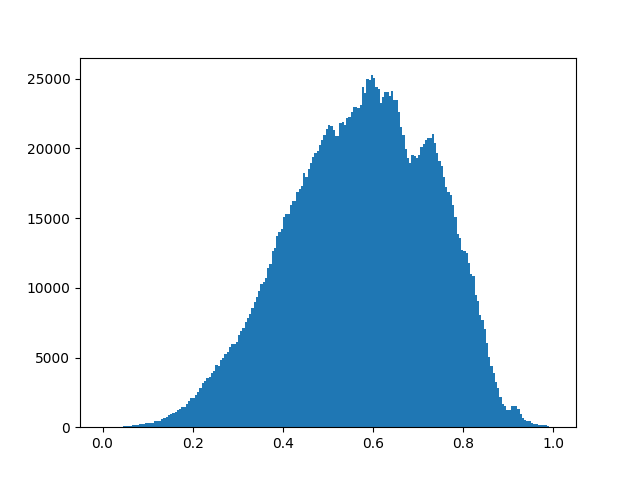

In [95]:
plt.figure()
plt.hist(u_data_sim_sc.flatten(),200)
plt.show()

<IPython.core.display.Javascript object>


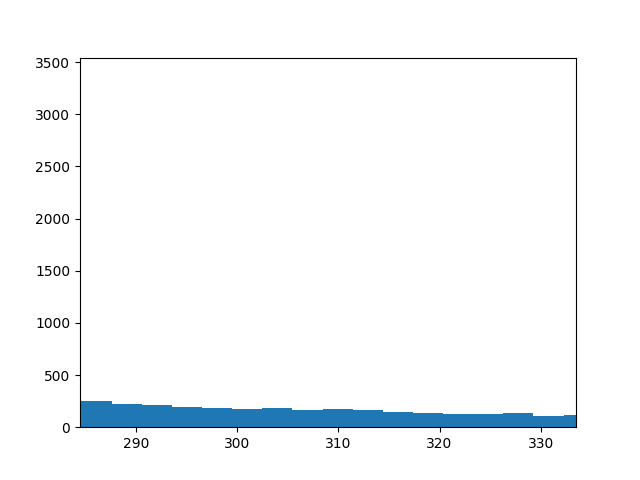

In [11]:
plt.figure()
plt.hist(bounded.flatten(),200, [5,600])
plt.show()

In [23]:
# Bound the feature to the [0,200] range simulating the rate code range
vmax=350
vmin=30
noise_max=100
bounded = scaled_input.copy()
bounded[bounded<vmin]=0  # below 10, no spike
bounded[bounded>vmax]=vmax # above 200, rate code saturates

# Calculate the noise value for each patch
sum_per_patch = bounded.sum(1)
noise = noise_max - sum_per_patch
noise[noise<0]=0 # also bounded in the range of [0,200]

# Append this noise feature to our feature vectors
bounded=np.append(bounded, noise[:,np.newaxis, :], axis=1)
print(bounded.shape) # new noise feature is now added

flat_bounded=bounded.reshape((bounded.shape[0], bounded.shape[1]*bounded.shape[2]))
print(flat_bounded.shape)

(1440, 9, 441)
(1440, 3969)


<IPython.core.display.Javascript object>


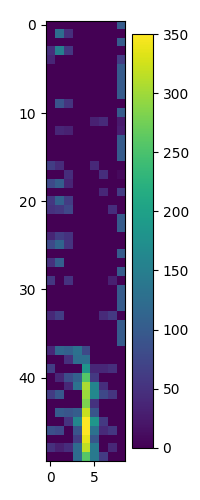

In [24]:
plt.figure(figsize=(2,5))
plt.imshow(bounded[145,:,50:100].T)
plt.colorbar()
plt.tight_layout()
plt.show()

In [58]:
importlib.reload(lvq.lvq1)
importlib.reload(lvq.lvq2)
from lvq.lvq1 import LVQ1
from lvq.lvq2 import LVQ2


n_epochs = 100
alpha = 0.01
alpha_decay = 'hill'
n_protos_per_class = 1
n_class = 20

# # Random train-test split
# test_size = 0.3
# random_state = np.random.randint(1000)

# X = flat_bounded
# y = labels
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

# Take every nth sample as training for each class
train_size_per_class = 1       # 1,2,3,4,6,8,9,12,18,24,36
mask = list(range(0,X.shape[0],int(72/train_size_per_class)))
X_train = X[mask]
X_test = np.delete(X, mask, axis=0)

y_train = y[mask]
y_test = np.delete(y, mask, axis=0)

mlvq3 = LVQ2(bmu_metric='dot_product', random_protos=True, alpha_decay=alpha_decay,
             n_protos_per_class=n_protos_per_class, 
             n_class=n_class)
mlvq3.train_prototypes(x_train=X_train, y_train=y_train, x_test=X_test , y_test=y_test,
                       alpha_start=alpha, n_epochs=n_epochs, test_each_epoch=True)
mlvq3.predict(X_test, y_test)

# mlvq2 = LVQ1(bmu_metric='euclidean', random_protos=True, alpha_decay=alpha_decay,
#              n_protos_per_class=n_protos_per_class, 
#              n_class=n_class)
# mlvq2.train_prototypes(x_train=X_train, y_train=y_train, x_test=X_test , y_test=y_test,
#                        alpha_start=alpha, n_epochs=n_epochs, test_each_epoch=True)
# mlvq2.predict(X_test, y_test)





example_protos = flat_bounded[np.concatenate([np.arange(n_protos_per_class)+72*n for n in range(n_class)]),:]
# mlvq2 = LVQ1(bmu_metric='euclidean', random_protos=False, alpha_decay=alpha_decay,
#              n_protos_per_class=n_protos_per_class, 
#              n_class=n_class,
#              init_protos=np.copy(example_protos))
# mlvq2.train_prototypes(data=flat_bounded, targets=labels, alpha_start=alpha, n_epochs=n_epochs)




Initial prototypes:
 [[  4.9   0.    7.  ...  75.9 135.5 115.8]
 [  4.4   0.    8.7 ...  60.8  85.2  89.1]
 [  3.7   0.    6.6 ...  60.5  73.8  81.3]
 ...
 [  3.7   0.   10.7 ...  94.8 128.3  98.8]
 [  2.7   0.   34.9 ...  57.   79.6  96.3]
 [  8.7   0.   10.2 ...  71.8  98.6  83. ]]
>epoch=0, lrate=0.010, error=45589.291, tr_err=0.900, test_err=0.939
>epoch=1, lrate=0.010, error=45413.397, tr_err=0.850, test_err=0.938
>epoch=2, lrate=0.010, error=45296.696, tr_err=0.850, test_err=0.930
>epoch=3, lrate=0.010, error=45348.284, tr_err=0.850, test_err=0.933
>epoch=4, lrate=0.010, error=45207.535, tr_err=0.850, test_err=0.912
>epoch=5, lrate=0.010, error=45103.505, tr_err=0.750, test_err=0.905
>epoch=6, lrate=0.010, error=44953.024, tr_err=0.750, test_err=0.900
>epoch=7, lrate=0.010, error=44853.279, tr_err=0.750, test_err=0.890
>epoch=8, lrate=0.010, error=44652.845, tr_err=0.700, test_err=0.888
>epoch=9, lrate=0.010, error=44675.891, tr_err=0.650, test_err=0.875
>epoch=10, lrate=0.010, e

<IPython.core.display.Javascript object>


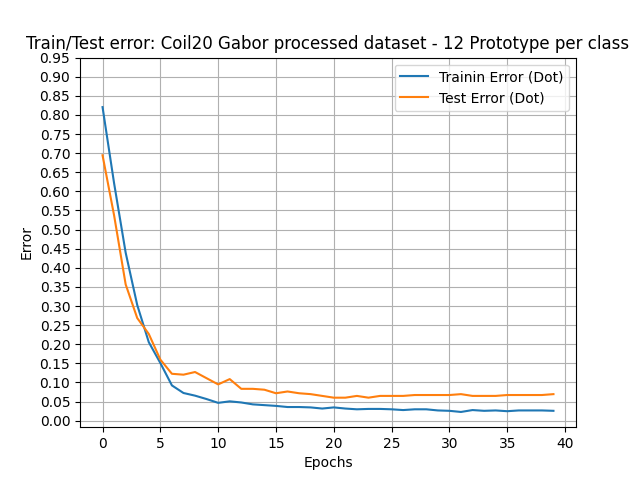

Text(0.5, 1.0, 'Train/Test error: Coil20 Gabor processed dataset - 12 Prototype per class')

In [56]:
plt.figure()
plt.plot(mlvq3.train_errors)
plt.plot(mlvq3.test_errors)
plt.yticks(np.arange(0,1,0.05))
plt.grid()

plt.legend(["Trainin Error (Dot)", 
            "Test Error (Dot)"])
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.title("Train/Test error: Coil20 Gabor processed dataset - 12 Prototype per class")

In [ ]:
n_epochs = 40
alpha = 0.02
alpha_decay = 'hill'
n_class = 20
max_n_proto = 20
test_size = 0.3
random_state = np.random.randint(1000)

#---------------------------------------------------------------------------------------------------
X = flat_bounded
y = labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
#---------------------------------------------------------------------------------------------------

lvqs = []
for n in range(1,max_n_proto):
    lvqs.append(LVQ2(bmu_metric='dot_product', random_protos=True, alpha_decay=alpha_decay,
                     n_protos_per_class=n, n_class=n_class))
    
    lvqs[n-1].train_prototypes(x_train=X_train, y_train=y_train, x_test=X_test , y_test=y_test,
                               alpha_start=alpha, n_epochs=n_epochs, test_each_epoch=True)

<IPython.core.display.Javascript object>


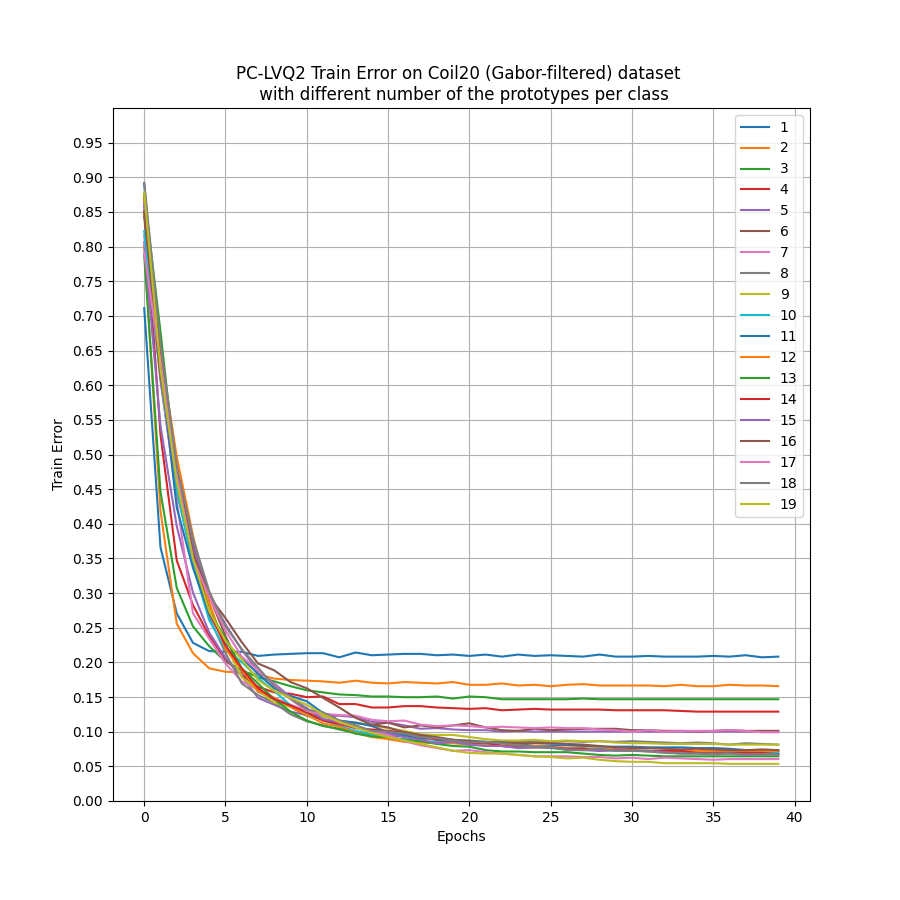

In [87]:
plt.figure(figsize=(9,9))
for n in range(1,max_n_proto):
    plt.plot(lvqs[n-1].train_errors)

plt.ylim([0,1])
plt.yticks(np.arange(0,1,0.05))
plt.grid()
plt.legend(labels=np.arange(1,max_n_proto))
plt.xlabel("Epochs")
plt.ylabel("Train Error")
plt.title("PC-LVQ2 Train Error on Coil20 (Gabor-filtered) dataset \n with different number of the prototypes per class")

plt.show()

<IPython.core.display.Javascript object>


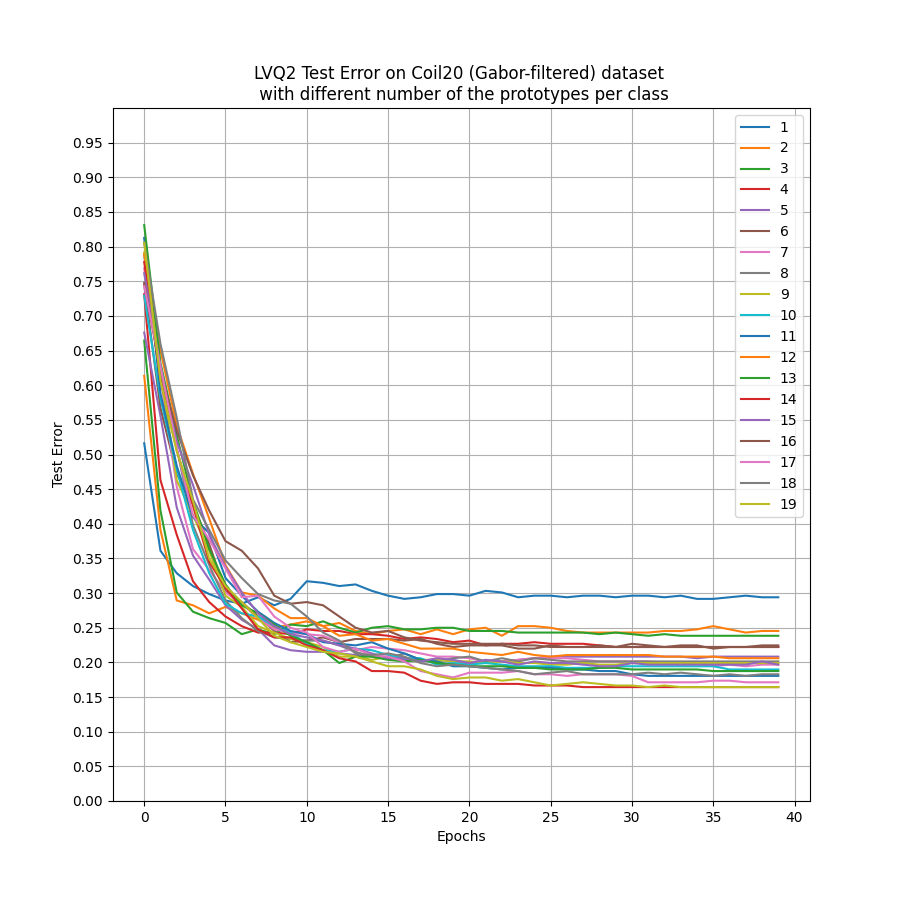

In [88]:
plt.figure(figsize=(9,9))
for n in range(1,max_n_proto):
    plt.plot(lvqs[n-1].test_errors)
    
plt.ylim([0,1])
plt.yticks(np.arange(0,1,0.05))
plt.grid()
plt.legend(labels=np.arange(1,max_n_proto))
plt.xlabel("Epochs")
plt.ylabel("Test Error")
plt.title("LVQ2 Test Error on Coil20 (Gabor-filtered) dataset \n with different number of the prototypes per class")

plt.show()

In [29]:
importlib.reload(lvq.lvq1)
importlib.reload(lvq.lvq2)
from lvq.lvq1 import LVQ1
from lvq.lvq2 import LVQ2

X = flat_bounded
y = labels
# Take every nth sample as training for each class

#---------------------------------------------------------------------------------------------------
n_epochs = 100
alpha = 0.01
alpha_decay = 'hill'
n_class = 20
max_n_proto = 20
n_sample_per_class = int(X.shape[0]/n_class)

#---------------------------------------------------------------------------------------------------


lvqs = []
# n_train_samples = [1,2,3,4,6,8,9,12,18,24,36]
training_ratios = np.arange(0.02,0.54,0.04)
for ind, n in enumerate(training_ratios):
    
    n_tr_sample_per_class = int(n_sample_per_class*training_ratios[ind])
    mask = list(range(0,X.shape[0],int(n_sample_per_class/n_tr_sample_per_class)))
    X_train = X[mask]
    X_test = np.delete(X, mask, axis=0)
    y_train = y[mask]
    y_test = np.delete(y, mask, axis=0)
    
    n_protos_per_class = n_tr_sample_per_class if n_tr_sample_per_class<16 else 16
    print("training_ratio: ", training_ratios[ind])
    print("n_tr_sample_per_class: ", n_tr_sample_per_class)
    print("n_protos_per_class: ", n_protos_per_class)
    lvqs.append(LVQ2(bmu_metric='dot_product', random_protos=True, alpha_decay=alpha_decay,
                     n_protos_per_class=n_protos_per_class, n_class=n_class))
    
    lvqs[ind].train_prototypes(x_train=X_train, y_train=y_train, x_test=X_test , y_test=y_test,
                               alpha_start=alpha, n_epochs=n_epochs, test_each_epoch=True)

training_ratio:  0.02
n_tr_sample_per_class:  1
n_protos_per_class:  1
Initial prototypes:
 [[  4.4   0.   17.6 ...  59.6 113.5 123.3]
 [ 12.5   0.   14.  ... 106.3 115.8 113.8]
 [  1.4   0.    2.  ...  84.2 100.6  86.1]
 ...
 [  4.8   0.   28.1 ... 149.1 100.2  84.9]
 [  6.6   0.   43.7 ... 109.  118.9  83.3]
 [  3.3   0.    6.2 ...  85.9  83.4  92.6]]
>epoch=0, lrate=0.010, error=45809.798, tr_err=0.950, test_err=0.958
>epoch=1, lrate=0.010, error=45547.531, tr_err=0.950, test_err=0.956
>epoch=2, lrate=0.010, error=45541.576, tr_err=0.950, test_err=0.960
>epoch=3, lrate=0.010, error=45441.349, tr_err=0.950, test_err=0.946
>epoch=4, lrate=0.010, error=45417.965, tr_err=0.950, test_err=0.961
>epoch=5, lrate=0.010, error=45422.485, tr_err=0.950, test_err=0.945
>epoch=6, lrate=0.010, error=45367.100, tr_err=0.900, test_err=0.942
>epoch=7, lrate=0.010, error=45190.328, tr_err=0.850, test_err=0.940
>epoch=8, lrate=0.010, error=45248.334, tr_err=0.850, test_err=0.944
>epoch=9, lrate=0.010, 

>epoch=4, lrate=0.010, error=182643.412, tr_err=0.650, test_err=0.783
>epoch=5, lrate=0.010, error=180877.691, tr_err=0.613, test_err=0.757
>epoch=6, lrate=0.010, error=179685.934, tr_err=0.600, test_err=0.745
>epoch=7, lrate=0.010, error=177948.072, tr_err=0.562, test_err=0.722
>epoch=8, lrate=0.010, error=176101.242, tr_err=0.537, test_err=0.696
>epoch=9, lrate=0.010, error=174456.450, tr_err=0.487, test_err=0.678
>epoch=10, lrate=0.010, error=172939.023, tr_err=0.463, test_err=0.662
>epoch=11, lrate=0.010, error=170957.541, tr_err=0.400, test_err=0.629
>epoch=12, lrate=0.010, error=168713.500, tr_err=0.388, test_err=0.612
>epoch=13, lrate=0.010, error=166879.193, tr_err=0.325, test_err=0.580
>epoch=14, lrate=0.010, error=165015.904, tr_err=0.300, test_err=0.561
>epoch=15, lrate=0.010, error=163059.242, tr_err=0.275, test_err=0.562
>epoch=16, lrate=0.010, error=161321.631, tr_err=0.275, test_err=0.513
>epoch=17, lrate=0.010, error=158477.778, tr_err=0.225, test_err=0.503
>epoch=18, l

>epoch=10, lrate=0.010, error=296651.074, tr_err=0.410, test_err=0.597
>epoch=11, lrate=0.010, error=291951.091, tr_err=0.375, test_err=0.569
>epoch=12, lrate=0.010, error=287693.916, tr_err=0.361, test_err=0.569
>epoch=13, lrate=0.010, error=284420.400, tr_err=0.340, test_err=0.553
>epoch=14, lrate=0.010, error=280950.136, tr_err=0.299, test_err=0.529
>epoch=15, lrate=0.010, error=275220.947, tr_err=0.285, test_err=0.488
>epoch=16, lrate=0.010, error=272653.790, tr_err=0.257, test_err=0.480
>epoch=17, lrate=0.010, error=268743.796, tr_err=0.222, test_err=0.444
>epoch=18, lrate=0.010, error=265168.515, tr_err=0.208, test_err=0.441
>epoch=19, lrate=0.010, error=261886.335, tr_err=0.188, test_err=0.414
>epoch=20, lrate=0.010, error=258164.197, tr_err=0.188, test_err=0.421
>epoch=21, lrate=0.010, error=254518.837, tr_err=0.167, test_err=0.387
>epoch=22, lrate=0.010, error=251884.499, tr_err=0.139, test_err=0.370
>epoch=23, lrate=0.010, error=248980.599, tr_err=0.125, test_err=0.363
>epoch

>epoch=16, lrate=0.010, error=371315.897, tr_err=0.170, test_err=0.358
>epoch=17, lrate=0.010, error=365399.534, tr_err=0.155, test_err=0.344
>epoch=18, lrate=0.010, error=359096.486, tr_err=0.126, test_err=0.342
>epoch=19, lrate=0.010, error=354182.701, tr_err=0.112, test_err=0.316
>epoch=20, lrate=0.010, error=349590.017, tr_err=0.097, test_err=0.300
>epoch=21, lrate=0.010, error=343693.051, tr_err=0.083, test_err=0.301
>epoch=22, lrate=0.010, error=339580.871, tr_err=0.073, test_err=0.292
>epoch=23, lrate=0.010, error=336045.386, tr_err=0.073, test_err=0.285
>epoch=24, lrate=0.009, error=332281.662, tr_err=0.068, test_err=0.276
>epoch=25, lrate=0.009, error=327930.237, tr_err=0.068, test_err=0.276
>epoch=26, lrate=0.009, error=324903.589, tr_err=0.063, test_err=0.273
>epoch=27, lrate=0.009, error=321784.782, tr_err=0.063, test_err=0.263
>epoch=28, lrate=0.009, error=318711.819, tr_err=0.058, test_err=0.260
>epoch=29, lrate=0.009, error=315474.892, tr_err=0.063, test_err=0.256
>epoch

>epoch=22, lrate=0.010, error=403773.921, tr_err=0.117, test_err=0.279
>epoch=23, lrate=0.010, error=399838.270, tr_err=0.113, test_err=0.276
>epoch=24, lrate=0.009, error=396119.172, tr_err=0.104, test_err=0.262
>epoch=25, lrate=0.009, error=391377.726, tr_err=0.092, test_err=0.248
>epoch=26, lrate=0.009, error=389125.078, tr_err=0.087, test_err=0.255
>epoch=27, lrate=0.009, error=385819.129, tr_err=0.079, test_err=0.243
>epoch=28, lrate=0.009, error=382813.348, tr_err=0.079, test_err=0.235
>epoch=29, lrate=0.009, error=379763.196, tr_err=0.079, test_err=0.227
>epoch=30, lrate=0.009, error=377576.310, tr_err=0.067, test_err=0.220
>epoch=31, lrate=0.009, error=374903.396, tr_err=0.058, test_err=0.221
>epoch=32, lrate=0.009, error=372740.492, tr_err=0.054, test_err=0.218
>epoch=33, lrate=0.008, error=370344.013, tr_err=0.050, test_err=0.212
>epoch=34, lrate=0.008, error=367919.693, tr_err=0.046, test_err=0.206
>epoch=35, lrate=0.008, error=365794.392, tr_err=0.046, test_err=0.201
>epoch

>epoch=28, lrate=0.009, error=539142.970, tr_err=0.036, test_err=0.160
>epoch=29, lrate=0.009, error=535597.249, tr_err=0.036, test_err=0.159
>epoch=30, lrate=0.009, error=532563.203, tr_err=0.036, test_err=0.155
>epoch=31, lrate=0.009, error=529256.137, tr_err=0.036, test_err=0.161
>epoch=32, lrate=0.009, error=526738.140, tr_err=0.031, test_err=0.160
>epoch=33, lrate=0.008, error=523761.429, tr_err=0.031, test_err=0.156
>epoch=34, lrate=0.008, error=521130.617, tr_err=0.028, test_err=0.155
>epoch=35, lrate=0.008, error=518530.831, tr_err=0.025, test_err=0.160
>epoch=36, lrate=0.008, error=516000.034, tr_err=0.028, test_err=0.156
>epoch=37, lrate=0.008, error=514307.171, tr_err=0.031, test_err=0.156
>epoch=38, lrate=0.007, error=512401.614, tr_err=0.033, test_err=0.149
>epoch=39, lrate=0.007, error=510612.774, tr_err=0.033, test_err=0.146
>epoch=40, lrate=0.007, error=508831.622, tr_err=0.031, test_err=0.147
>epoch=41, lrate=0.007, error=507080.596, tr_err=0.025, test_err=0.146
>epoch

>epoch=34, lrate=0.008, error=529796.307, tr_err=0.047, test_err=0.157
>epoch=35, lrate=0.008, error=526992.114, tr_err=0.047, test_err=0.154
>epoch=36, lrate=0.008, error=524479.951, tr_err=0.044, test_err=0.150
>epoch=37, lrate=0.008, error=521820.412, tr_err=0.044, test_err=0.144
>epoch=38, lrate=0.007, error=519715.630, tr_err=0.039, test_err=0.143
>epoch=39, lrate=0.007, error=517270.179, tr_err=0.042, test_err=0.145
>epoch=40, lrate=0.007, error=515877.652, tr_err=0.042, test_err=0.143
>epoch=41, lrate=0.007, error=513613.135, tr_err=0.039, test_err=0.144
>epoch=42, lrate=0.007, error=511813.402, tr_err=0.042, test_err=0.143
>epoch=43, lrate=0.006, error=510771.979, tr_err=0.042, test_err=0.138
>epoch=44, lrate=0.006, error=508734.094, tr_err=0.033, test_err=0.139
>epoch=45, lrate=0.006, error=507272.676, tr_err=0.036, test_err=0.136
>epoch=46, lrate=0.006, error=505920.761, tr_err=0.033, test_err=0.138
>epoch=47, lrate=0.006, error=504733.946, tr_err=0.033, test_err=0.135
>epoch

>epoch=40, lrate=0.007, error=668752.904, tr_err=0.027, test_err=0.147
>epoch=41, lrate=0.007, error=666613.798, tr_err=0.027, test_err=0.148
>epoch=42, lrate=0.007, error=665668.895, tr_err=0.027, test_err=0.144
>epoch=43, lrate=0.006, error=663526.224, tr_err=0.025, test_err=0.145
>epoch=44, lrate=0.006, error=662138.242, tr_err=0.025, test_err=0.149
>epoch=45, lrate=0.006, error=660693.398, tr_err=0.025, test_err=0.141
>epoch=46, lrate=0.006, error=659373.080, tr_err=0.025, test_err=0.140
>epoch=47, lrate=0.006, error=657855.888, tr_err=0.023, test_err=0.139
>epoch=48, lrate=0.005, error=656793.106, tr_err=0.021, test_err=0.137
>epoch=49, lrate=0.005, error=655112.875, tr_err=0.021, test_err=0.137
>epoch=50, lrate=0.005, error=654233.754, tr_err=0.021, test_err=0.142
>epoch=51, lrate=0.005, error=653418.416, tr_err=0.021, test_err=0.136
>epoch=52, lrate=0.005, error=652132.192, tr_err=0.021, test_err=0.135
>epoch=53, lrate=0.004, error=651120.215, tr_err=0.021, test_err=0.137
>epoch

>epoch=46, lrate=0.006, error=671695.223, tr_err=0.027, test_err=0.130
>epoch=47, lrate=0.006, error=670105.201, tr_err=0.027, test_err=0.128
>epoch=48, lrate=0.005, error=669348.012, tr_err=0.025, test_err=0.128
>epoch=49, lrate=0.005, error=667636.889, tr_err=0.025, test_err=0.132
>epoch=50, lrate=0.005, error=667232.400, tr_err=0.025, test_err=0.132
>epoch=51, lrate=0.005, error=666424.212, tr_err=0.027, test_err=0.126
>epoch=52, lrate=0.005, error=665576.572, tr_err=0.025, test_err=0.128
>epoch=53, lrate=0.004, error=664404.910, tr_err=0.025, test_err=0.128
>epoch=54, lrate=0.004, error=663617.342, tr_err=0.025, test_err=0.131
>epoch=55, lrate=0.004, error=662892.070, tr_err=0.025, test_err=0.130
>epoch=56, lrate=0.004, error=661829.258, tr_err=0.025, test_err=0.128
>epoch=57, lrate=0.004, error=661359.056, tr_err=0.025, test_err=0.127
>epoch=58, lrate=0.003, error=660895.406, tr_err=0.025, test_err=0.124
>epoch=59, lrate=0.003, error=660067.520, tr_err=0.025, test_err=0.124
>epoch

>epoch=52, lrate=0.005, error=974843.695, tr_err=0.024, test_err=0.058
>epoch=53, lrate=0.004, error=973901.133, tr_err=0.025, test_err=0.060
>epoch=54, lrate=0.004, error=973159.786, tr_err=0.024, test_err=0.060
>epoch=55, lrate=0.004, error=971900.213, tr_err=0.024, test_err=0.058
>epoch=56, lrate=0.004, error=971445.886, tr_err=0.025, test_err=0.058
>epoch=57, lrate=0.004, error=970368.595, tr_err=0.025, test_err=0.060
>epoch=58, lrate=0.003, error=969883.448, tr_err=0.022, test_err=0.060
>epoch=59, lrate=0.003, error=969357.674, tr_err=0.024, test_err=0.060
>epoch=60, lrate=0.003, error=968180.325, tr_err=0.022, test_err=0.058
>epoch=61, lrate=0.003, error=968183.068, tr_err=0.024, test_err=0.057
>epoch=62, lrate=0.003, error=967615.602, tr_err=0.024, test_err=0.058
>epoch=63, lrate=0.003, error=966635.419, tr_err=0.022, test_err=0.058
>epoch=64, lrate=0.003, error=966125.442, tr_err=0.024, test_err=0.058
>epoch=65, lrate=0.003, error=965485.540, tr_err=0.022, test_err=0.058
>epoch

>epoch=58, lrate=0.003, error=971692.769, tr_err=0.015, test_err=0.065
>epoch=59, lrate=0.003, error=970898.159, tr_err=0.014, test_err=0.065
>epoch=60, lrate=0.003, error=970385.912, tr_err=0.014, test_err=0.065
>epoch=61, lrate=0.003, error=969710.242, tr_err=0.015, test_err=0.065
>epoch=62, lrate=0.003, error=969210.898, tr_err=0.013, test_err=0.065
>epoch=63, lrate=0.003, error=968217.909, tr_err=0.013, test_err=0.065
>epoch=64, lrate=0.003, error=967833.629, tr_err=0.014, test_err=0.065
>epoch=65, lrate=0.003, error=967263.010, tr_err=0.013, test_err=0.065
>epoch=66, lrate=0.002, error=966573.516, tr_err=0.011, test_err=0.065
>epoch=67, lrate=0.002, error=966071.047, tr_err=0.013, test_err=0.065
>epoch=68, lrate=0.002, error=965505.260, tr_err=0.014, test_err=0.065
>epoch=69, lrate=0.002, error=965025.751, tr_err=0.011, test_err=0.065
>epoch=70, lrate=0.002, error=964653.589, tr_err=0.013, test_err=0.065
>epoch=71, lrate=0.002, error=964160.502, tr_err=0.011, test_err=0.067
>epoch

>epoch=64, lrate=0.003, error=960325.809, tr_err=0.022, test_err=0.064
>epoch=65, lrate=0.003, error=960242.868, tr_err=0.022, test_err=0.064
>epoch=66, lrate=0.002, error=959743.097, tr_err=0.024, test_err=0.064
>epoch=67, lrate=0.002, error=958994.226, tr_err=0.022, test_err=0.064
>epoch=68, lrate=0.002, error=958783.102, tr_err=0.022, test_err=0.064
>epoch=69, lrate=0.002, error=958100.990, tr_err=0.022, test_err=0.064
>epoch=70, lrate=0.002, error=957831.548, tr_err=0.022, test_err=0.064
>epoch=71, lrate=0.002, error=957950.107, tr_err=0.022, test_err=0.064
>epoch=72, lrate=0.002, error=957406.604, tr_err=0.022, test_err=0.064
>epoch=73, lrate=0.002, error=956947.572, tr_err=0.022, test_err=0.062
>epoch=74, lrate=0.002, error=956696.917, tr_err=0.022, test_err=0.062
>epoch=75, lrate=0.002, error=956403.270, tr_err=0.022, test_err=0.061
>epoch=76, lrate=0.002, error=956314.033, tr_err=0.022, test_err=0.062
>epoch=77, lrate=0.001, error=955717.809, tr_err=0.022, test_err=0.064
>epoch

>epoch=70, lrate=0.002, error=966715.209, tr_err=0.019, test_err=0.072
>epoch=71, lrate=0.002, error=965710.805, tr_err=0.017, test_err=0.071
>epoch=72, lrate=0.002, error=965357.899, tr_err=0.017, test_err=0.074
>epoch=73, lrate=0.002, error=965532.937, tr_err=0.019, test_err=0.071
>epoch=74, lrate=0.002, error=965175.713, tr_err=0.019, test_err=0.072
>epoch=75, lrate=0.002, error=964867.114, tr_err=0.019, test_err=0.071
>epoch=76, lrate=0.002, error=964796.705, tr_err=0.021, test_err=0.074
>epoch=77, lrate=0.001, error=964715.922, tr_err=0.022, test_err=0.071
>epoch=78, lrate=0.001, error=963763.797, tr_err=0.019, test_err=0.071
>epoch=79, lrate=0.001, error=964042.338, tr_err=0.021, test_err=0.071
>epoch=80, lrate=0.001, error=963794.704, tr_err=0.019, test_err=0.068
>epoch=81, lrate=0.001, error=963437.366, tr_err=0.021, test_err=0.069
>epoch=82, lrate=0.001, error=963270.534, tr_err=0.022, test_err=0.067
>epoch=83, lrate=0.001, error=963209.110, tr_err=0.021, test_err=0.067
>epoch

<IPython.core.display.Javascript object>


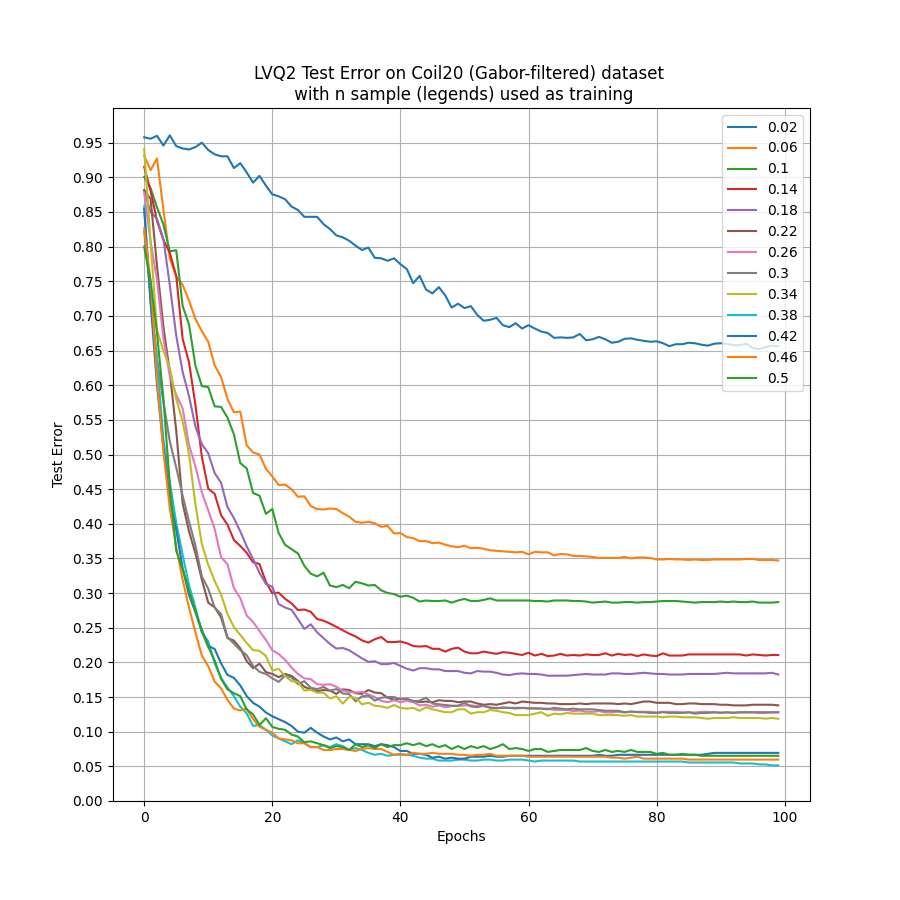

In [30]:
plt.figure(figsize=(9,9))
for n in range(len(lvqs)):
    plt.plot(lvqs[n].test_errors)
    
plt.ylim([0,1])
plt.yticks(np.arange(0,1,0.05))
plt.grid()
plt.legend(labels=np.around(training_ratios,2))
plt.xlabel("Epochs")
plt.ylabel("Test Error")
plt.title("LVQ2 Test Error on Coil20 (Gabor-filtered) dataset \n with n sample (legends) used as training")

plt.show()

<IPython.core.display.Javascript object>


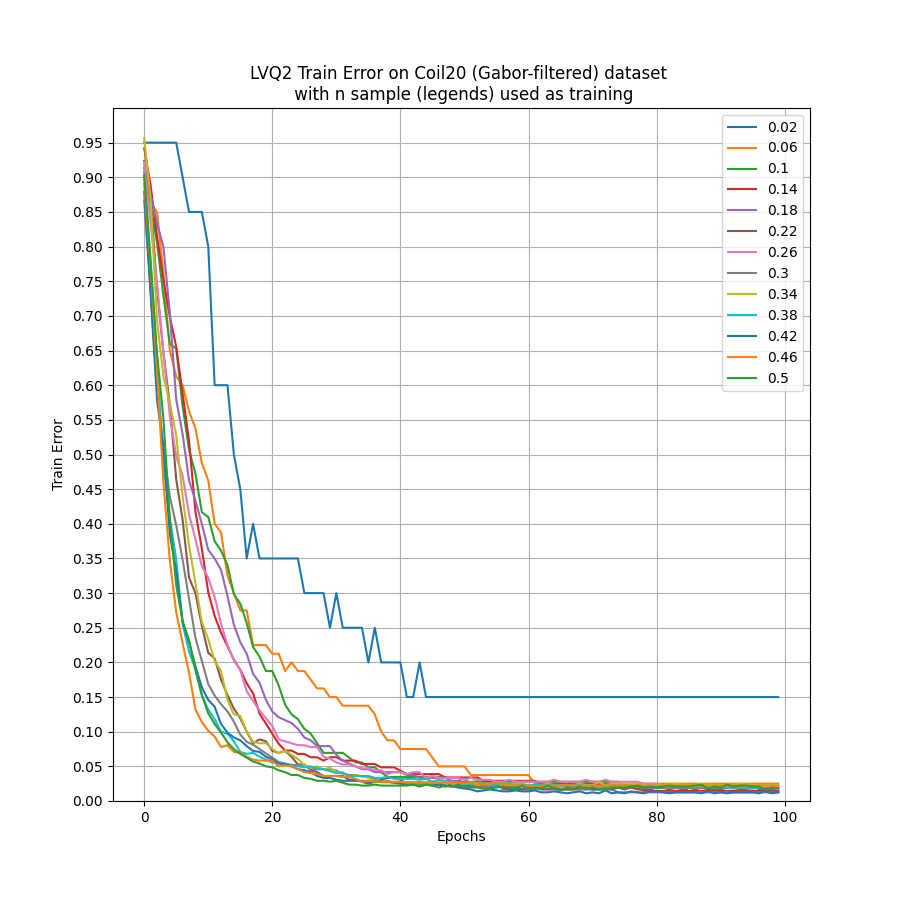

In [31]:
plt.figure(figsize=(9,9))
for n in range(len(lvqs)):
    plt.plot(lvqs[n].train_errors)
    
plt.ylim([0,1])
plt.yticks(np.arange(0,1,0.05))
plt.grid()
plt.legend(labels=np.around(training_ratios,2))
plt.xlabel("Epochs")
plt.ylabel("Train Error")
plt.title("LVQ2 Train Error on Coil20 (Gabor-filtered) dataset \n with n sample (legends) used as training")

plt.show()

<IPython.core.display.Javascript object>


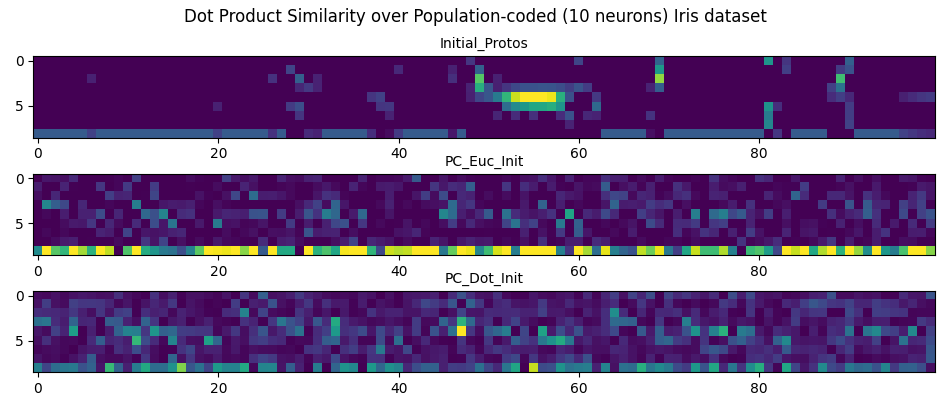

In [57]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(9.5,4))
proto_ind = 60
ind_max = 100
im1 = ax1.imshow(example_protos[proto_ind,:].reshape((9,441))[:,:100])
im2 = ax2.imshow(mlvq2.prototypes[proto_ind,:].reshape((9,441))[:,:100])
im3 = ax3.imshow(mlvq3.prototypes[proto_ind,:].reshape((9,441))[:,:100])
ax1.set_title("Initial_Protos", fontsize=10)
ax2.set_title("PC_Euc_Init", fontsize=10)
ax3.set_title("PC_Dot_Init", fontsize=10)
# fig.colorbar(im1, ax=ax1)
# fig.colorbar(im2, ax=ax2)
# fig.colorbar(im3, ax=ax3)
fig.suptitle("Dot Product Similarity over Population-coded (10 neurons) Iris dataset")
plt.tight_layout()
plt.show()